In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax

In [7]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
with open("img.pickle", "rb") as file:
    img = pickle.load(file)

K = img['camera_matrix']
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = img["depthPixels"].shape
intrinsics = b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0)

rgbd = b.RGBD(
    img["rgbPixels"],
    img["depthPixels"],
    b.t3d.pybullet_pose_to_transform(img["camera_pose"]),
    intrinsics
)

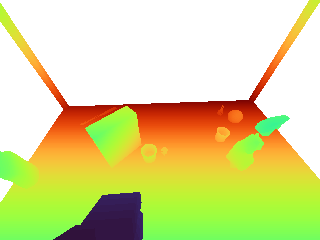

In [3]:
b.get_depth_image(rgbd.depth)

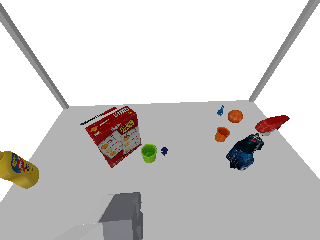

In [4]:
b.get_rgb_image(rgbd.rgb)

In [35]:
scaling_factor = 0.3
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd, scaling_factor)

In [36]:
rgbd_scaled_down.intrinsics

Intrinsics(height=72, width=96, fx=39.375, fy=39.375, cx=47.85, cy=35.85, near=0.001, far=10000.0)

In [37]:
b.show_cloud("obs",
     b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3)        
)

In [40]:
cloud = b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3)
cloud = cloud[cloud[:,2] < 3.0]
table_pose = b.utils.find_plane(
    np.array(cloud), 0.01
)
face_child = 3

camera_pose = jnp.eye(4)
table_pose_in_cam_frame = b.t3d.inverse_pose(camera_pose) @ table_pose
if table_pose_in_cam_frame[2,2] > 0:
    table_pose = table_pose @ b.t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)

In [41]:
b.clear()
b.show_cloud("1", cloud)
b.show_pose("table", table_pose)

In [42]:
# Add every ply file from the model dir using b.RENDERER.add_mesh_from_file(mesh_path)
b.setup_renderer(rgbd_scaled_down.intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
for model_path in glob.glob(os.path.join(model_dir, "*.ply")):
    b.RENDERER.add_mesh_from_file(model_path, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (96, 96, 1024)


In [48]:
constraints = genjax.choice_map({})
constraints["parent_0"] = -1
for i in range(1,8):
    constraints["parent_"+str(i)] = 0
    constraints["face_parent_"+str(i)] = 2
    constraints["face_child_"+str(i)] = 3

constraints["id_0"] = jnp.int32(3)
constraints["camera_pose"] = jnp.eye(4)
constraints["root_pose_0"] = table_pose
constraints["image"] = b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)
constraints["variance"] = 0.0001
constraints["outlier_prob"] = 0.0001

In [49]:
constraints["parent_0"]

-1

In [52]:
importance_jit = jax.jit(b.model.importance)
key = jax.random.PRNGKey(10)

weight, trace = importance_jit(key, constraints, (
    jnp.arange(8),  # 8 objects
    jnp.arange(21), # 22 object category indices
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]), # pose bounds
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]), # contact bounds
    b.RENDERER.model_box_dims,
    1.0, 1.0 # outlier volume, focal length
)) # TODO: ask Nishad about how to set some of these